# Figure 6: Relationships between network size *N* and radius *γ*

## Introduction

In this notebook notebook, we analyse the relationship between network size *N* and radius $ γ =  \sqrt{N}σ $.

The radius *γ* ranges between 0 and 2 with 0.1 increment and *N* can be 3, 4, 10, or 50.

First, we sample 1,000 random matrices for each *γ* and *n* combination. To generate a random matrix we also need a variance ($σ^2$), vr.

Thus, $ vr = (\frac{γ}{\sqrt{N}})^2 $. <br><br>

We want to record the following values:
- **% of stable matrices without diffusion**, i.e., the proportion of the 1,000 random matrices generated for a particular *n* and *γ* combination is stable. 
- **% unstable due to diffusion**, i.e., the proportion of previously stable matrices turns unstable upon introduction of diffusion (excluding Hopf and unidentified instabilities).
- **% Turing unstable matrices**, i.e., the proportion of the sum of Turing 1a, 1b, 2a, 2b instabilities to the 1,000 sampled matrices. 
- **% Turing I instability**, i.e., the proportion of only Turing 1a and 1b instabilities to the 1,000 sampled matrices.

***

### Import Libraries

In [ ]:
import numpy as np
from scipy.signal import argrelextrema
import pandas as pd 
import os 
import math
import seaborn as sns
import matplotlib.pyplot as plt

***

### Define Matrix Generating Function

Defining a function that generates random matrices without diffusion. 

The parameters *n* and *vr* represent the number of sampled matrices and the variance $σ^2$.

In [ ]:
def gen_matrix_F(n, vr):
    
    I = np.eye(n)       # Identity matrix representing degradation
    mu = 0              # Mean
    
    B = mu + np.sqrt(vr) * np.random.randn(n, n)    # Random matrix generator, allowing diagonal term to be non-zero
    np.fill_diagonal(B, 0)
    
    A = -I + B              # Modified matrix form
   
    D = np.zeros((n, n))    # Initialize diffusion matrix
    
    return A, D

***

### Initialise network size *N* and radius *γ* values. 

In [ ]:
N = [3, 4, 10, 50]
y = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]

results = []

***

### Generate Random Matrices

In this example, we generate 1,000 random matrices for each *γ* and network size *N* combination

We record the values below in a dataframe for convenience. These values will be used to calculate the percentages mentioned above. 

- **1,000** sampled random matrices

1. **len(srm)** - # of stable sampled random matrices

2. **len(urm)** - # of stable matrices turing unstable due to diffusion

3. **len(th)** - # of observed Hopf instabilities 

4. **len(tu)** - # of unidenntified instabilities 

5. **len(t1a)** - # of Turing 1a instabilities

6. **len(t1b)** - # of Turing 1b instabilities

7. **len(t2a)** - # of Turing 2a instabilities

8. **len(t2b)** - # of Turing 2b instabilities

1. stable_without_diffusion = $ (\frac{len(srm)} {1000}) * 100 $

2. unstable_due_to_diffusion = $ (\frac{len(urm) - len(th) - len(tu)}{len(srm)}) * 100 $

3. turing_unstable = $ (\frac{len(t1a) + len(t1b) + len(t2a) + len(t2b)}{1000}) * 100 $

4. type_1_unstable = $ (\frac{len(t1a) + len(t1b)}{1000}) * 100 $

In [2]:
# Iterate over each combination of n and gamma
for n in N:
    for gamma in y:
        var = (gamma / math.sqrt(n)) ** 2
        rm = []  # random matrices 
        for i in range(1000):
            m = gen_matrix_F(n, var)[0]        # size, variance
            rm.append(m)

        # stable without diffusion
        srm = []
        for m in rm:
            ev = np.linalg.eigvals(m)
            if np.max(np.real(ev)) < 0:
                srm.append(m)
        stable_without_diffusion = (len(srm) / 1000) * 100

        D = gen_matrix_F(n, var)[1]                # size, variance
        D[0, 0] = 1
        D[1, 1] = 100
        k = np.arange(0, 101, 0.2) 

        # filter stable and hopf
        urm = []
        t1a = []
        t1ar = []
        t1ai = []
        t1b = []
        t1br = []
        t1bi = []
        t2a = []
        t2ar = []
        t2ai = []
        t2b = []
        t2br = []
        t2bi = []
        tu = []
        tur = []
        tui = []
        th = []
        thr = []
        thi = []
        turing_matrices = []
#___________________________________________
# Linear Stability Analysis
        for m in srm:
            Em = []
            Emi = []
            for i in range(len(k)):
                R = m - D * (k[i] ** 2)
                eigval = np.linalg.eigvals(R)
                Em.append(np.max(np.real(eigval)))
                idx_max = np.argmax(np.real(eigval))
                Emi.append(np.imag(eigval[idx_max]))
            a = np.max(Em)
            index = np.argmax(Em)
            nEm = np.array(Em)
            if a > 0:
                urm.append(m)
                if Emi[index] == 0:
                    numZeroCrossing = np.count_nonzero(np.diff(np.sign(Em)))  # Count zero crossings
                    numpositivelocalmaxima = np.sum(nEm[argrelextrema(nEm, np.greater)] > 0) > 0
                    if numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 0:
                        t1a.append(m)
                        turing_matrices.append(m)
                        t1ar.append(Em)
                        t1ai.append(Emi)
                    elif numpositivelocalmaxima > 0 and numZeroCrossing == 1:
                        t1b.append(m)
                        turing_matrices.append(m)
                        t1br.append(Em)
                        t1bi.append(Emi)
                    elif numpositivelocalmaxima == 0 and numZeroCrossing % 2 == 1:
                        t2a.append(m)
                        t2ar.append(Em)
                        t2ai.append(Emi)
                    elif numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 1:
                        t2b.append(m)
                        t2br.append(Em)
                        t2bi.append(Emi)
                    else:
                        tu.append(m)
                        tur.append(Em)
                        tui.append(Emi)
                else:
                    th.append(m)
                    thr.append(Em)
                    thi.append(Emi)
        result = {
                'n': n,
                '\u03B3': gamma,
                'srm': len(srm),
                'urm': len(urm),
                'th': len(th),
                'tu': len(tu),
                't1a': len(t1a),
                't1b': len(t1b),
                't2a': len(t2a),
                't2b': len(t2b)
            }
        
        results.append(result)
results_df = pd.DataFrame(results)

### Updates: 
- ZeroDivision errors are handled, NaN values appended to the dataframe whenever an error occurs.

- The Notebook is automated, no need to manually input *γ* or *N*.

### Final dataframe 

In [3]:
results_df.head()

,n,γ,srm,urm,th,tu,t1a,t1b,t2a,t2b
0,3,0.0,1000,0,0,0,0,0,0,0
1,3,0.1,1000,0,0,0,0,0,0,0
2,3,0.2,1000,0,0,0,0,0,0,0
3,3,0.3,1000,0,0,0,0,0,0,0
4,3,0.4,1000,0,0,0,0,0,0,0


***

### Data Visualisation

- Subplot A: Stable without Diffusion

/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/398096721.py:20: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.xaxis.get_major_ticks()[-1].label.set_horizontalalignment('right')
/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/398096721.py:21: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.xaxis.get_major_ticks()[0].label.set_horizontalalignment('left')
/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/398096721.py:22: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.yaxis.get_major_ticks()[-1].label.set_verticalalignment('top')


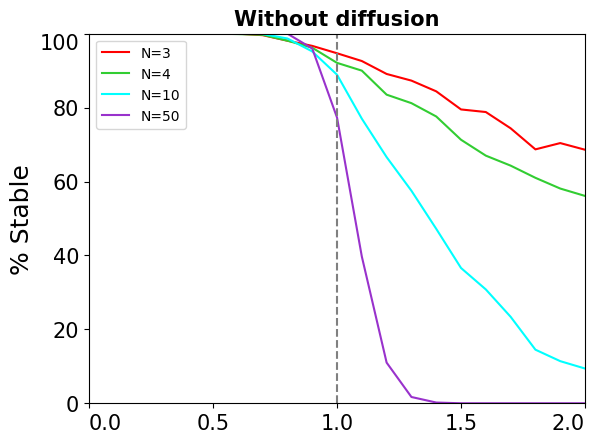

In [4]:
# STABLE WITHOUT DIFFUSION 
copy = results_df

results_df['srm_scaled'] = results_df['srm'] / 10
color_palette = {3: 'red', 4: 'limegreen', 10: 'cyan', 50: 'darkorchid'}
fig, ax = plt.subplots()

for n in N:
    subset = results_df[results_df['n'] == n]
    sns.lineplot(x='\u03B3', y='srm_scaled', data=subset, label=f'N={n}', color=color_palette[n], ax=ax)

ax.set_ylabel('% Stable', fontsize=18)
ax.set_title('Without diffusion', fontweight='bold', fontsize=15)
ax.set_xlabel(None)
# Set limits and ticks
ax.set_ylim(0, 100)
ax.set_xlim(0, 2)
ax.set_xticks([0, 0.5, 1, 1.5, 2])

ax.xaxis.get_major_ticks()[-1].label.set_horizontalalignment('right')
ax.xaxis.get_major_ticks()[0].label.set_horizontalalignment('left')
ax.yaxis.get_major_ticks()[-1].label.set_verticalalignment('top')

ax.axvline(x=1, color='gray', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

- Subplot B: Unstable due to Diffusion

/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/3443879969.py:22: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.xaxis.get_major_ticks()[-1].label.set_horizontalalignment('right')
/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/3443879969.py:23: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.xaxis.get_major_ticks()[0].label.set_horizontalalignment('left')
/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/3443879969.py:24: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.yaxis.get_major_ticks()[-1].label.set_verticalalignment('top')


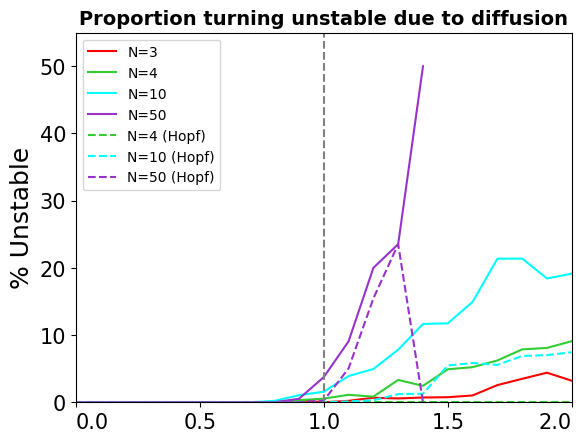

In [21]:
# UNSTABLE DUE TO DIFFUSION
results_df['usm_scaled'] = ((results_df['urm'] - results_df['th'] - results_df['tu'])/results_df['srm'])*100
results_df['hopf'] = (results_df['th']/results_df['srm'])*100
fig, ax = plt.subplots()
hopf_n = [4, 10, 50]
for n in N:
    subset = results_df[results_df['n'] == n]
    sns.lineplot(x='\u03B3', y='usm_scaled', data=subset, label=f'N={n}', color=color_palette[n], ax=ax)
for n in hopf_n:
    subset = results_df[results_df['n'] == n]
    sns.lineplot(x='\u03B3', y='hopf', data=subset, label=f'N={n} (Hopf)', color=color_palette[n], ax=ax, linestyle='--')

ax.set_ylabel('% Unstable', fontsize=18)
ax.set_title('Proportion turning unstable due to diffusion', fontweight='bold', fontsize=14)
ax.set_xlabel(None)
# Set limits and ticks
ax.set_ylim(0, 55)
ax.set_xlim(0, 2)
ax.set_xticks([0, 0.5, 1, 1.5, 2])

ax.legend(loc='upper left')
ax.xaxis.get_major_ticks()[-1].label.set_horizontalalignment('right')
ax.xaxis.get_major_ticks()[0].label.set_horizontalalignment('left')
ax.yaxis.get_major_ticks()[-1].label.set_verticalalignment('top')

ax.axvline(x=1, color='gray', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

- Subplot C: Turing Unstable

/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/1641056221.py:18: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.xaxis.get_major_ticks()[-1].label.set_horizontalalignment('right')
/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/1641056221.py:19: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.xaxis.get_major_ticks()[0].label.set_horizontalalignment('left')
/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/1641056221.py:20: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.yaxis.get_major_ticks()[-1].label.set_verticalalignment('top')


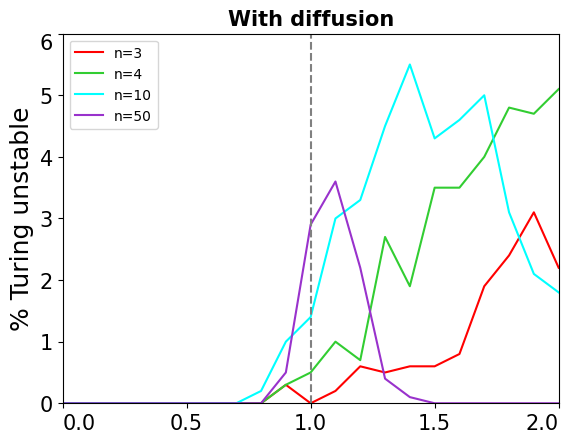

In [23]:
# TURING UNSTABLE
results_df['turing'] = (results_df['t1a'] + results_df['t1b'] + results_df['t2a'] + results_df['t2b'])/10

fig, ax = plt.subplots()

for n in N:
    subset = results_df[results_df['n'] == n]
    sns.lineplot(x='\u03B3', y='turing', data=subset, label=f'n={n}', color=color_palette[n], ax=ax)

ax.set_ylabel('% Turing unstable', fontsize=18)
ax.set_title('With diffusion', fontweight='bold', fontsize=15)
ax.set_xlabel(None)
# Set limits and ticks
ax.set_ylim(0, 6)
ax.set_xlim(0, 2)
ax.set_xticks([0, 0.5, 1, 1.5, 2])

ax.xaxis.get_major_ticks()[-1].label.set_horizontalalignment('right')
ax.xaxis.get_major_ticks()[0].label.set_horizontalalignment('left')
ax.yaxis.get_major_ticks()[-1].label.set_verticalalignment('top')

ax.axvline(x=1, color='gray', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

- Subplot D: Type 1 Instability

/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/1892168200.py:18: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.xaxis.get_major_ticks()[-1].label.set_horizontalalignment('right')
/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/1892168200.py:19: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.xaxis.get_major_ticks()[0].label.set_horizontalalignment('left')
/var/folders/qz/bfvt0415421bz2m84jqf7qyc0000gn/T/ipykernel_4061/1892168200.py:20: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  ax.yaxis.get_major_ticks()[-1].label.set_verticalalignment('top')


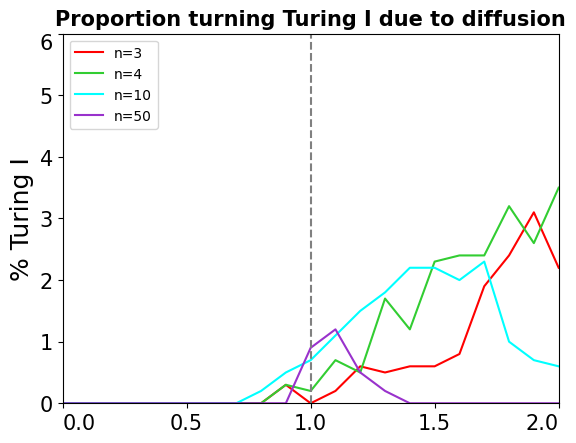

In [24]:
# TYPE 1 INSTABILITY
results_df['type_1'] = (results_df['t1a'] + results_df['t1b'])/10

fig, ax = plt.subplots()

for n in N:
    subset = results_df[results_df['n'] == n]
    sns.lineplot(x='\u03B3', y='type_1', data=subset, label=f'n={n}', color=color_palette[n], ax=ax)

ax.set_ylabel('% Turing I', fontsize=18)
ax.set_title('Proportion turning Turing I due to diffusion', fontweight='bold', fontsize=15)
ax.set_xlabel(None)
# Set limits and ticks
ax.set_ylim(0, 6)
ax.set_xlim(0, 2)
ax.set_xticks([0, 0.5, 1, 1.5, 2])

ax.xaxis.get_major_ticks()[-1].label.set_horizontalalignment('right')
ax.xaxis.get_major_ticks()[0].label.set_horizontalalignment('left')
ax.yaxis.get_major_ticks()[-1].label.set_verticalalignment('top')
ax.legend(loc='upper left')
ax.axvline(x=1, color='gray', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

***

## Note
In order to smooth the plots one can use *np.convole*, example code below:<br><br>



window_size = 3

n3_smmothed= np.convolve(data3, np.ones(window_size)/window_size, mode='valid')

n4_smoothed = np.convolve(data4, np.ones(window_size)/window_size, mode='valid')

n10_smoothed = np.convolve(data10, np.ones(window_size)/window_size, mode='valid')

n50_smoothed = np.convolve(data50, np.ones(window_size)/window_size, mode='valid')